# Creating a simple Titanic Survior predictor

Create a simple model to calculate the chance of surviving. Note: currently working on optimizing it, right now the optimization is at ~75%.

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

## Loading and visualizing data

Load in the Titanic data from Kaggle and divide into a train and a test set. Use Pandas library to look at some cool plots.

In [5]:
# training data
train_set = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') 
# testing data
eval_set = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
# get the y values (the 'answers' of who survived or not) for the training and the evaluation set 
y_train = train_set.pop('survived')
y_eval = eval_set.pop('survived')
# 627 entries with 9 features
train_set.shape

(627, 9)

In [6]:
# Analyze the data bit
train_set.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


Visualize the data. To some extent, we can use this to verify that our machine learning model works

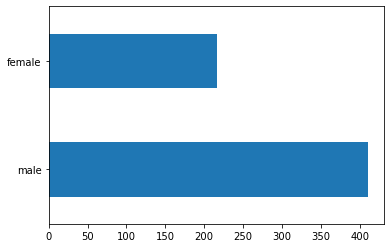

In [7]:
# Male / female count
train_set['sex'].value_counts().plot(kind='barh')

Text(0.5, 0, 'Survived comparison (%)')

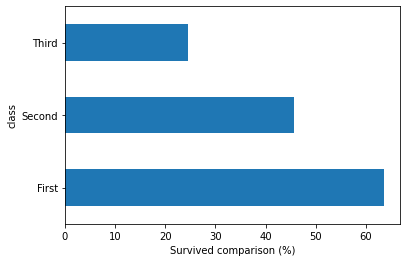

In [8]:
# Survivorship by travel class. We can see the more wealthy people had a higher survivorship.
pd.concat([train_set, y_train], axis=1).groupby('class').survived.mean().multiply(100).plot(kind='barh').set_xlabel('Survived comparison (%)')

Text(0.5, 0, 'Survived comparison (%)')

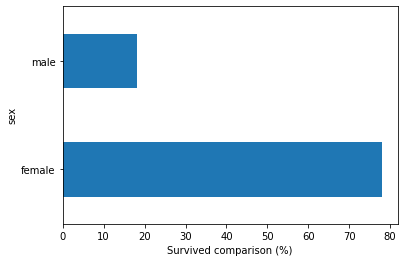

In [9]:
# Survivorship by gender
pd.concat([train_set, y_train], axis=1).groupby('sex').survived.mean().multiply(100).plot(kind='barh').set_xlabel('Survived comparison (%)')

[Text(0, 0.5, 'Are alone?'),
 Text(0.5, 0, 'Survived comparison (%)'),
 Text(0.5, 1.0, 'Chance of surviving the Titanic')]

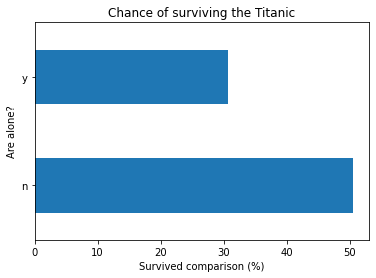

In [10]:
# Shows that being a loner significantly lowered your chances of surviving
pd.concat([train_set, y_train], axis=1).groupby('alone').survived.mean().multiply(100).plot(kind='barh').set(xlabel='Survived comparison (%)', ylabel='Are alone?', title='Chance of surviving the Titanic')

Before training, all descriptive, 'categorical' features needed to be converted into a numeric format (such as male/female = 0/1) for the training algorithm

In [16]:
CAT_FEATURES = ['sex', 'class', 'deck', 'alone', 'n_siblings_spouses', 'parch', 'embark_town']
NUM_FEATURES = ['fare', 'age']
features = []
for feature_name in CAT_FEATURES:
  vocabulary = train_set[feature_name].unique() # Get a list of all unique values for a feature (i.e. 'male' and 'female')
  # Link the feature with the unique list of values to create a numeric mapping
  features.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

# No conversion needed here
for feature_name in NUM_FEATURES:
  features.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32)) # Directly create float types


## Create the input function

The function will be used to divide the data into batches. It is adapted from the TensorFlow documentation.

In [22]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): 
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)  
    return ds 
  return input_function 

# Create two input functions: one for training data set and one for evaluation data set
input_fn_train = make_input_fn(train_set, y_train)
input_fn_eval = make_input_fn(eval_set, y_eval, num_epochs=1, shuffle=False) # Only need 1 epoch for this

## Start training

Will be using linear regression. Define a Tensor Flow linear classifier with the features defined and then guage its accuracy for the evaluation data set.

In [23]:
linear_est = tf.estimator.LinearClassifier(feature_columns=features)

linear_est.train(input_fn_train)  # train
result = linear_est.evaluate(input_fn_eval) # Get the result for the evaluation data set, NOT the training data set (bias)

# TensorFlow puts out a lot of console information during training, so to avoid clutter, should clear it
clear_output()  
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7651515


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Chance of surviving (%)'),
 Text(0.5, 1.0, 'Frequency vs chance of surviving (%)')]

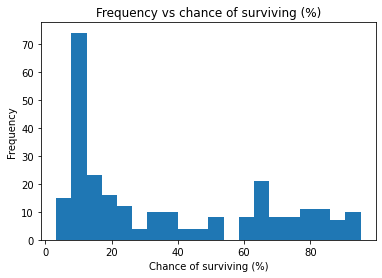

In [35]:
pred_vals = list(linear_est.predict(input_fn_eval))
clear_output() # Again, clear the console

# Get 2nd item from the array as the first item contains the chance of 'not surviving', but we want the complement of that
probabilities = pd.Series([prob['probabilities'][1] for prob in pred_vals])
probabilities.multiply(100).plot(kind='hist', bins=20, title='predicted probabilities').set(xlabel='Chance of surviving (%)', ylabel='Frequency', title='Frequency vs chance of surviving (%)')